## Week 7

1. Full Model(XGBoost): age + personality + orienation + gender 

    * `Age`,`Personality` as continous variable, `orientation`, `gender` as categorical
    * Change all the variables into categorical. 2 groups for `Age`, 3 groups for `Personality`.
    
2. Give up `Age`: personality + orienation + gender

3. Grid Search & XGBoost

    * `n_estimators`,`learning_rate`, `max_depth`,`sample`,`min_child_weight`,`gamma`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.model_selection import KFold, RandomizedSearchCV

from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

In [3]:
import xgboost as xgb

## Data Preprocessing

In [4]:
data = pd.read_csv('data.csv',sep='\t')

In [5]:
data['stress_score'] = data.apply(lambda row: row.Q1A + row.Q6A + row.Q8A + row.Q11A + row.Q12A + row.Q14A
                                       + row.Q18A + row.Q22A + row.Q27A + row.Q29A + row.Q32A + row.Q33A + row.Q35A + row.Q39A,
                                       axis=1)

In [6]:
data['stress_category'] = data["stress_score"]

In [7]:
data.loc[ data['stress_category'] <= 39, 'stress_category'] = 0
data.loc[ data['stress_category'] > 39, 'stress_category'] = 1

In [8]:
data['anxiety_score'] = data.apply(lambda row: row.Q2A + row.Q4A + row.Q7A + row.Q9A + row.Q15A + row.Q19A
                                       + row.Q20A + row.Q23A + row.Q25A + row.Q28A + row.Q30A + row.Q36A + row.Q40A + row.Q41A,
                                       axis=1)

In [9]:
data['anxiety_category'] = data['anxiety_score']

In [10]:
data.loc[ data['anxiety_category'] <= 28, 'anxiety_category'] = 0
data.loc[ data['anxiety_category'] > 28, 'anxiety_category'] = 1

In [11]:
data['depression_score'] = data.apply(lambda row: row.Q3A + row.Q5A + row.Q10A + row.Q13A + row.Q16A + row.Q17A
                                       + row.Q21A + row.Q24A + row.Q26A + row.Q31A + row.Q34A + row.Q37A + row.Q38A + row.Q42A,
                                       axis=1)

In [12]:
data['depression_category'] = data['depression_score']

In [13]:
data.loc[ data['depression_category'] <= 34, 'depression_category'] = 0
data.loc[ data['depression_category'] > 34, 'depression_category'] = 1

In [14]:
data['Extroversion'] = data.apply(lambda row: row.TIPI1 + 
                                  (7-row.TIPI6), axis=1)

In [15]:
data['Agreeableness'] = data.apply(lambda row: row.TIPI7 + 
                                   (7-row.TIPI2), axis=1)

In [16]:
data['Conscientiousness'] = data.apply(lambda row: row.TIPI3 + 
                                       (7-row.TIPI8), axis=1)

In [17]:
data['Emotional_stability'] = data.apply(lambda row: row.TIPI9 + 
                                         (7-row.TIPI4), axis=1)

In [18]:
data['Openness_to_experience'] = data.apply(lambda row: row.TIPI5 + 
                                            (7-row.TIPI10), axis=1)

In [19]:
data = data[data.TIPI1 != 0]
data = data[data.TIPI2 != 0]
data = data[data.TIPI3 != 0]
data = data[data.TIPI4 != 0]
data = data[data.TIPI5 != 0]
data = data[data.TIPI6 != 0]
data = data[data.TIPI7 != 0]
data = data[data.TIPI8 != 0]
data = data[data.TIPI9 != 0]
data = data[data.TIPI10 != 0]

In [20]:
data['depression_score'] = data['depression_score']-14
data['anxiety_score'] = data['anxiety_score']-14
data['stress_score'] = data['stress_score']-14

In [21]:
data.loc[data['religion']==5,'religion'] = 4
data.loc[data['religion']==6,'religion'] = 4
data.loc[data['religion']==7,'religion'] = 4

In [22]:
data = data[data.VCL6 != 1]
data = data[data.VCL9 != 1]
data = data[data.VCL12 != 1]

In [23]:
data.loc[data['age']==1996,'age'] = 22
data.loc[data['age']==1998,'age'] = 20
data.loc[data['age']==1993,'age'] = 25
data.loc[data['age']==1991,'age'] = 27

data = data[data.age != 223]
data = data[data.age != 115]
data = data[data.age != 117]

In [24]:
data = data[data.gender != 0]
data = data[data.gender != 3]

In [25]:
data = data[data.orientation != 0]
data = data[data.orientation != 5]

In [26]:
data.loc[data['orientation']== 1, 'orientation'] = 0
data.loc[data['orientation']> 1, 'orientation'] = 1

In [27]:
data.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,stress_category,anxiety_score,anxiety_category,depression_score,depression_category,Extroversion,Agreeableness,Conscientiousness,Emotional_stability,Openness_to_experience
0,4,28,3890,4,25,2122,2,16,1944,4,...,1,34,1,27,1,1,9,9,1,13
2,3,7,5784,1,33,4373,4,41,3242,1,...,0,12,0,39,1,3,7,4,8,10
4,2,36,3215,2,13,7731,3,5,4156,4,...,1,40,1,32,1,4,7,4,4,9
5,1,18,6116,1,28,3193,2,2,12542,1,...,0,6,0,13,0,2,13,11,12,7
6,1,20,4325,1,34,4009,2,38,3604,3,...,0,19,1,31,1,7,8,10,7,5


In [28]:
data['Extroversion_category'] = data['Extroversion']

In [29]:
data.loc[data['Extroversion_category']<=5,'Extroversion_category'] = 0
data.loc[(data['Extroversion_category']>=6)&(data['Extroversion_category']<=10),'Extroversion_category'] = 1
data.loc[data['Extroversion_category']>=11,'Extroversion_category'] = 2

In [30]:
data['Agreeableness_category'] = data['Agreeableness']

In [31]:
data.loc[data['Agreeableness_category']<=5,'Agreeableness_category'] = 0
data.loc[(data['Agreeableness_category']>=6)&(data['Agreeableness_category']<=10),'Agreeableness_category'] = 1
data.loc[data['Agreeableness_category']>=11,'Agreeableness_category'] = 2

In [32]:
data['Conscientiousness_category'] = data['Conscientiousness']

In [33]:
data.loc[data['Conscientiousness_category']<=5,'Conscientiousness_category'] = 0
data.loc[(data['Conscientiousness_category']>=6)&(data['Conscientiousness_category']<=10),'Conscientiousness_category'] = 1
data.loc[data['Conscientiousness_category']>=11,'Conscientiousness_category'] = 2

In [34]:
data['EM_category'] = data['Emotional_stability']

In [35]:
data.loc[data['EM_category']<=5,'EM_category'] = 0
data.loc[(data['EM_category']>=6)&(data['EM_category']<=10),'EM_category'] = 1
data.loc[data['EM_category']>=11,'EM_category'] = 2

In [36]:
data['OTE_category'] = data['Openness_to_experience']

In [37]:
data.loc[data['OTE_category']<=5,'OTE_category'] = 0
data.loc[(data['OTE_category']>=6)&(data['OTE_category']<=10),'OTE_category'] = 1
data.loc[data['OTE_category']>=11,'OTE_category'] = 2

In [38]:
data['age_category'] = data['age']

In [39]:
data.loc[data['age_category']<=20,'age_category'] = 0
data.loc[data['age_category']> 20,'age_category'] = 1

In [40]:
data.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Agreeableness,Conscientiousness,Emotional_stability,Openness_to_experience,Extroversion_category,Agreeableness_category,Conscientiousness_category,EM_category,OTE_category,age_category
0,4,28,3890,4,25,2122,2,16,1944,4,...,9,9,1,13,0,1,1,0,2,0
2,3,7,5784,1,33,4373,4,41,3242,1,...,7,4,8,10,0,1,0,1,1,0
4,2,36,3215,2,13,7731,3,5,4156,4,...,7,4,4,9,0,1,0,0,1,0
5,1,18,6116,1,28,3193,2,2,12542,1,...,13,11,12,7,0,2,2,2,1,0
6,1,20,4325,1,34,4009,2,38,3604,3,...,8,10,7,5,1,1,1,1,0,0


In [41]:
data.shape

(27489, 189)

## Depression Full Model (Original)

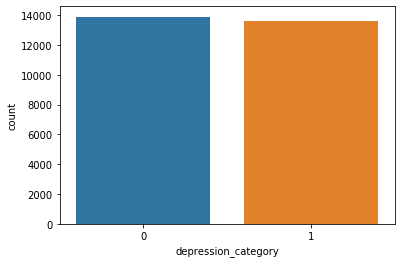

In [42]:
sns.countplot(data['depression_category'])

In [43]:
data_d = data.copy()

In [44]:
features = ['age','Extroversion',
       'Agreeableness', 'Conscientiousness', 'Emotional_stability',
       'Openness_to_experience','orientation','gender']

target = 'depression_category'

In [45]:
def train_xgb(dataset,feature,target):

    X_train,X_test,y_train,y_test = train_test_split(dataset[feature],
                                                    dataset[target],
                                                    test_size=0.3)
    
    model= xgb.XGBClassifier()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    coeff_df = pd.DataFrame(np.transpose(model.feature_importances_), 
                            X_train.columns, columns=['Coefficient']),

    score = accuracy_score(y_pred,y_test)
    matrix = confusion_matrix(y_pred,y_test)
    sns.heatmap(matrix,annot=True,cmap="YlGnBu")
    plt.show()

    print('Accuracy: {}'.format(score))
    return coeff_df, matrix

In [46]:
def grid_search(dataset,feature,target,dict_param,cv):
    
    X_train,X_test,y_train,y_test = train_test_split(dataset[feature],
                                                    dataset[target],
                                                    test_size=0.3)
    
    model = RandomizedSearchCV(estimator = xgb.XGBClassifier(), 
                               param_distributions = dict_param, n_iter = 100,
                               cv = cv, verbose=2, random_state=42, n_jobs = -1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    coeff = model.best_params_
    
    score = accuracy_score(y_pred,y_test)
    matrix = confusion_matrix(y_pred,y_test)
    sns.heatmap(matrix,annot=True,cmap="YlGnBu")
    plt.show()

    print('Accuracy: {}'.format(score))
    return coeff, matrix

In [47]:
def params_test(dataset,feature,target,param,param_list,cv):
    
    X_train,X_test,y_train,y_test = train_test_split(dataset[feature],
                                                    dataset[target],
                                                    test_size=0.3)
    
    model = xgb.XGBClassifier()
    
    train_scoreNum, test_scoreNum = validation_curve(model,
                                                X=X_train, y=y_train,
                                                param_name= param,
                                                param_range= param_list,
                                                cv=cv)

    plt.plot(param_list, train_scoreNum,label='Train_score')
    plt.plot(param_list, test_scoreNum,label='Test_score')
    plt.legend()
    plt.title("Accuracy vs. {}".format(param))
    plt.show()

In [48]:
def kfold_cv(dataset, features, target):
        
    model = xgb.XGBClassifier()
    scores = []

    
    cv = KFold(n_splits=10, random_state=42, shuffle=False)

    for train_index, test_index in cv.split(dataset):

        X_train = dataset.iloc[train_index][features]
        X_test = dataset.iloc[test_index][features]
        y_train = dataset.iloc[train_index][target]
        y_test = dataset.iloc[test_index][target]

        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        
    plt.plot(range(len(scores)), scores)
    plt.title("Cross Validation Scores")
    plt.show()
    
    return scores

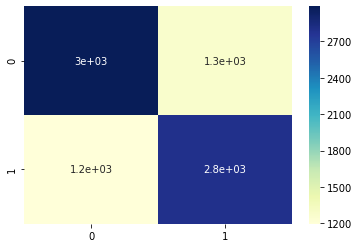

Accuracy: 0.701103431550867


((                        Coefficient
  age                        0.023368
  Extroversion               0.127215
  Agreeableness              0.024431
  Conscientiousness          0.108911
  Emotional_stability        0.595837
  Openness_to_experience     0.045256
  orientation                0.053088
  gender                     0.021895,), array([[2989, 1269],
        [1196, 2793]]))

In [49]:
train_xgb(data_d,features,target)

/Users/jinxiaowei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


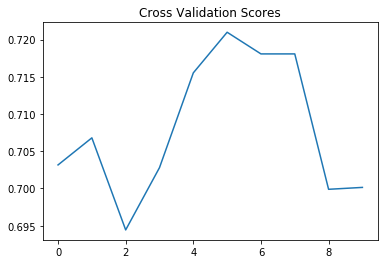

[0.7031647871953438,
 0.7068024736267734,
 0.6944343397599126,
 0.7028010185522008,
 0.7155329210622045,
 0.7209894507093488,
 0.7180793015642052,
 0.7180793015642052,
 0.6998908694070571,
 0.7001455604075691]

In [50]:
kfold_cv(data_d,features,target)

In [51]:
n_estimators = [100,500,1000]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 66.3min finished


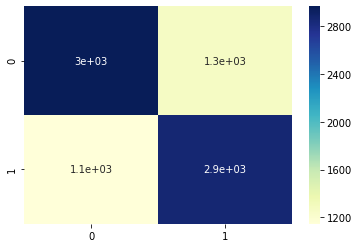

Accuracy: 0.7071662422699163


({'subsample': 1,
  'n_estimators': 500,
  'min_child_weight': 10,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2968, 1270],
        [1145, 2864]]))

In [52]:
grid_search(data_d,features,target,random_grid,5)

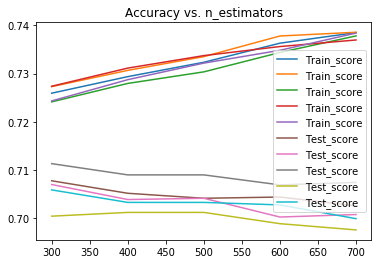

In [53]:
params_test(data_d,features,target,"n_estimators",[300,400,500,600,700],5)

In [54]:
n_estimators = [300,350,400,450,500]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [300, 350, 400, 450, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 45.8min finished


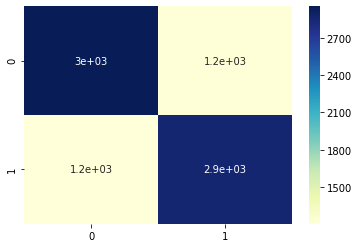

Accuracy: 0.7068024736267734


({'subsample': 1,
  'n_estimators': 450,
  'min_child_weight': 10,
  'max_depth': 10,
  'learning_rate': 0.1,
  'gamma': 5},
 array([[2956, 1216],
        [1202, 2873]]))

In [55]:
grid_search(data_d,features,target,random_grid,5)

## Depression Full Model (Categorical)

In [56]:
features = ['age_category','Extroversion_category',
       'Agreeableness_category', 'Conscientiousness_category', 'EM_category',
       'OTE_category','orientation','gender']

target = 'depression_category'

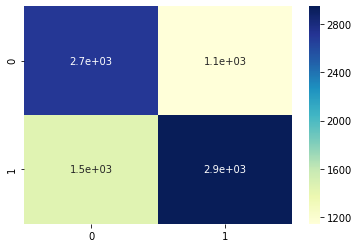

Accuracy: 0.6852188674669577


((                            Coefficient
  age_category                   0.017851
  Extroversion_category          0.163537
  Agreeableness_category         0.020202
  Conscientiousness_category     0.116745
  EM_category                    0.586091
  OTE_category                   0.048103
  orientation                    0.040998
  gender                         0.006472,), array([[2703, 1144],
        [1452, 2948]]))

In [57]:
train_xgb(data_d,features,target)

/Users/jinxiaowei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


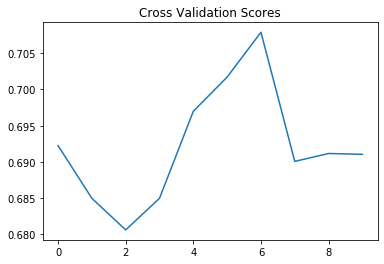

[0.6922517279010549,
 0.6849763550381958,
 0.6806111313204801,
 0.6849763550381958,
 0.6969807202619134,
 0.7017097126227719,
 0.7078937795562023,
 0.6900691160421971,
 0.6911604219716261,
 0.6910480349344978]

In [58]:
kfold_cv(data_d,features,target)

In [59]:
n_estimators = [100,500,1000]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 58.6min finished


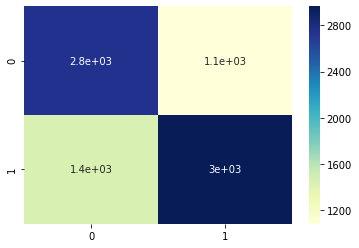

Accuracy: 0.6940705711167697


({'subsample': 0.8,
  'n_estimators': 1000,
  'min_child_weight': 10,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2758, 1080],
        [1443, 2966]]))

In [60]:
grid_search(data_d,features,target,random_grid,6)

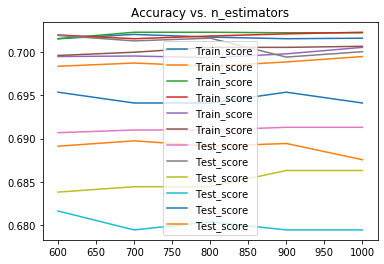

In [61]:
params_test(data_d,features,target,"n_estimators",[600,700,800,900,1000],6)

In [62]:
n_estimators = [600,800,850,900]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [600, 800, 850, 900], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 51.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 81.7min finished


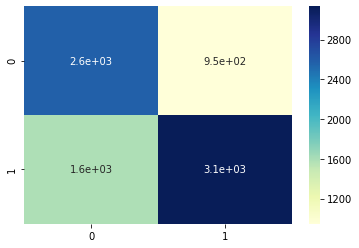

Accuracy: 0.692130471686674


({'subsample': 1,
  'n_estimators': 800,
  'min_child_weight': 5,
  'max_depth': 100,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2573,  947],
        [1592, 3135]]))

In [63]:
grid_search(data_d,features,target,random_grid,6)

## Anxiety Full Model (Original)

In [65]:
data_a = data.copy()

In [67]:
features = ['age','Extroversion',
       'Agreeableness', 'Conscientiousness', 'Emotional_stability',
       'Openness_to_experience','orientation','gender']

target = 'depression_category'

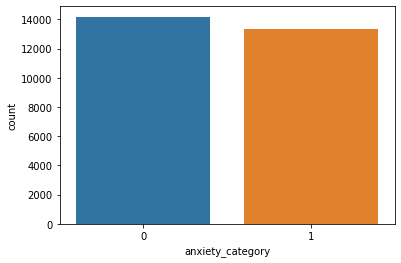

In [66]:
sns.countplot(data_a['anxiety_category'])

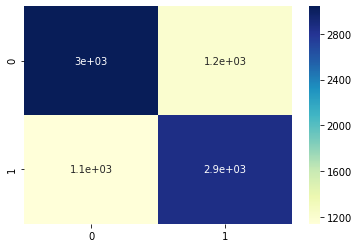

Accuracy: 0.7154116648478235


((                        Coefficient
  age                        0.023112
  Extroversion               0.133466
  Agreeableness              0.026284
  Conscientiousness          0.102303
  Emotional_stability        0.576424
  Openness_to_experience     0.060401
  orientation                0.058678
  gender                     0.019332,), array([[3039, 1206],
        [1141, 2861]]))

In [68]:
train_xgb(data_a,features,target)

/Users/jinxiaowei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


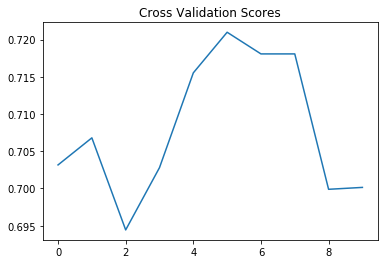

[0.7031647871953438,
 0.7068024736267734,
 0.6944343397599126,
 0.7028010185522008,
 0.7155329210622045,
 0.7209894507093488,
 0.7180793015642052,
 0.7180793015642052,
 0.6998908694070571,
 0.7001455604075691]

In [69]:
kfold_cv(data_a,features,target)

In [70]:
n_estimators = [100,500,1000]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 68.1min finished


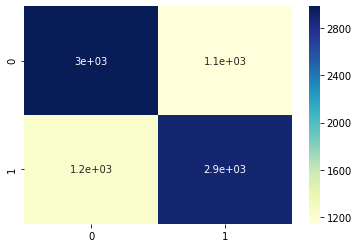

Accuracy: 0.7123802594882988


({'subsample': 0.8,
  'n_estimators': 500,
  'min_child_weight': 10,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2984, 1144],
        [1228, 2891]]))

In [71]:
grid_search(data_a,features,target,random_grid,5)

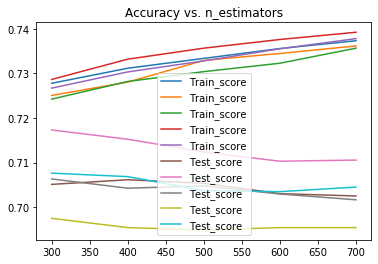

In [72]:
params_test(data_a,features,target,"n_estimators",[300,400,500,600,700],5)

In [73]:
n_estimators = [300,350,400,450,500]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [300, 350, 400, 450, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 53.3min finished


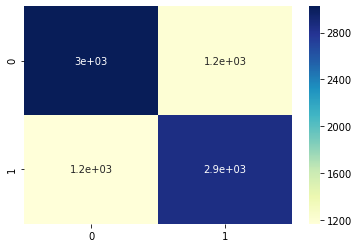

Accuracy: 0.7129865405602037


({'subsample': 0.8,
  'n_estimators': 450,
  'min_child_weight': 10,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[3024, 1199],
        [1168, 2856]]))

In [74]:
grid_search(data_a,features,target,random_grid,5)

## Anxiety Full Model (Categorical) 

In [75]:
features = ['age_category','Extroversion_category',
       'Agreeableness_category', 'Conscientiousness_category', 'EM_category',
       'OTE_category','orientation','gender']

target = 'anxiety_category'


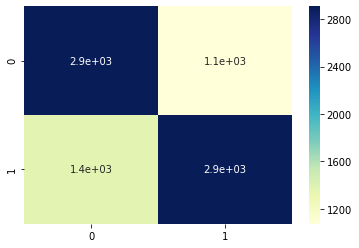

Accuracy: 0.7043773493391536


((                            Coefficient
  age_category                   0.098681
  Extroversion_category          0.027907
  Agreeableness_category         0.007396
  Conscientiousness_category     0.043856
  EM_category                    0.716286
  OTE_category                   0.041142
  orientation                    0.035454
  gender                         0.029278,), array([[2908, 1074],
        [1364, 2901]]))

In [76]:
train_xgb(data_a,features,target)

/Users/jinxiaowei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


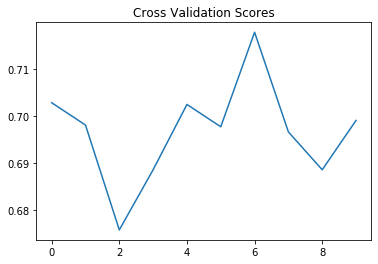

[0.7028010185522008,
 0.6980720261913423,
 0.6758821389596217,
 0.6886140414696253,
 0.7024372499090579,
 0.6977082575481993,
 0.7177155329210622,
 0.6966169516187705,
 0.6886140414696253,
 0.6990538573508006]

In [77]:
kfold_cv(data_a,features,target)

In [78]:
n_estimators = [100,500,1000]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 50.6min finished


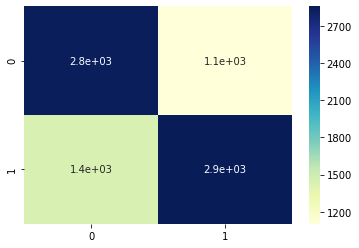

Accuracy: 0.691402934400388


({'subsample': 0.8,
  'n_estimators': 1000,
  'min_child_weight': 10,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2844, 1103],
        [1442, 2858]]))

In [79]:
grid_search(data_a,features,target,random_grid,6)

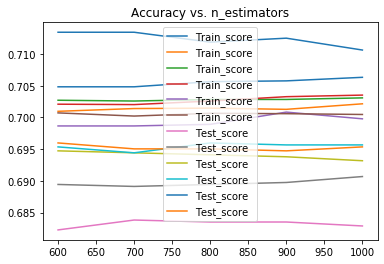

In [80]:
params_test(data_a,features,target,"n_estimators",[600,700,800,900,1000],6)

In [81]:
n_estimators = [600,800,1000]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [600, 800, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 51.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 83.9min finished


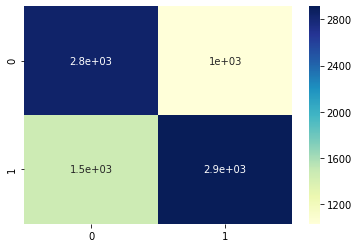

Accuracy: 0.6979507699769614


({'subsample': 0.8,
  'n_estimators': 1000,
  'min_child_weight': 10,
  'max_depth': 100,
  'learning_rate': 0.05,
  'gamma': 5},
 array([[2843, 1028],
        [1463, 2913]]))

In [82]:
grid_search(data_a,features,target,random_grid,6)

## Stress Full Model (Original) 

In [83]:
data_s = data.copy()

In [84]:
features = ['age','Extroversion',
       'Agreeableness', 'Conscientiousness', 'Emotional_stability',
       'Openness_to_experience','orientation','gender']

target = 'stress_category'

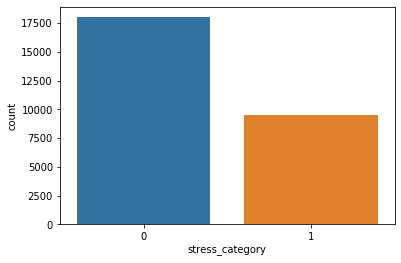

In [85]:
sns.countplot(data_s['stress_category'])

In [86]:
from imblearn.under_sampling import RandomUnderSampler

In [87]:
rus = RandomUnderSampler()
X_rus, y_rus= rus.fit_sample(data_s[features], data_s[target])

In [88]:
X_rus['stress_category'] = y_rus

In [89]:
data_s = X_rus.copy()

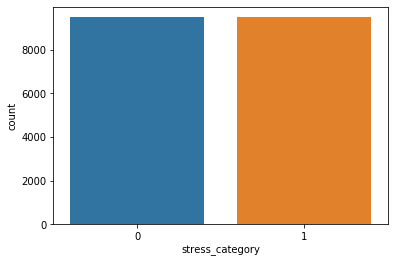

In [90]:
sns.countplot(data_s['stress_category'])

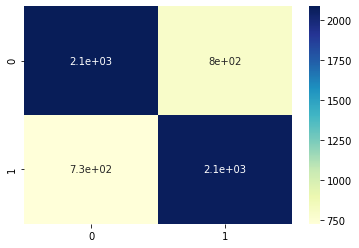

Accuracy: 0.7309314586994727


((                        Coefficient
  age                        0.030623
  Extroversion               0.028432
  Agreeableness              0.037680
  Conscientiousness          0.029771
  Emotional_stability        0.763733
  Openness_to_experience     0.032576
  orientation                0.019179
  gender                     0.058006,), array([[2086,  802],
        [ 729, 2073]]))

In [91]:
train_xgb(data_s,features,target)

/Users/jinxiaowei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


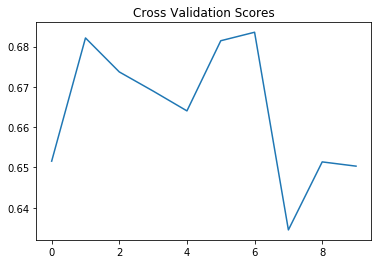

[0.6515550869794412,
 0.6821296784396416,
 0.6736953083816553,
 0.6689509752240379,
 0.6640295358649789,
 0.6814345991561181,
 0.6835443037974683,
 0.634493670886076,
 0.6513713080168776,
 0.6503164556962026]

In [92]:
kfold_cv(data_s,features,target)

In [93]:
n_estimators = [100,500,1000]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  9.1min finished


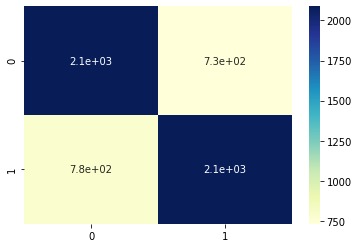

Accuracy: 0.7337434094903339


({'subsample': 1,
  'n_estimators': 1000,
  'min_child_weight': 1,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2088,  732],
        [ 783, 2087]]))

In [94]:
grid_search(data_s,features,target,random_grid,2)

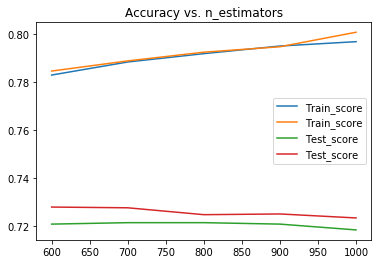

In [95]:
params_test(data_s,features,target,"n_estimators",[600,700,800,900,1000],2)

In [96]:
n_estimators = [600,650,700,750]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [600, 650, 700, 750], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 13.8min finished


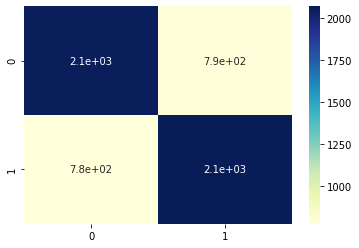

Accuracy: 0.7249560632688928


({'subsample': 0.8,
  'n_estimators': 700,
  'min_child_weight': 10,
  'max_depth': 100,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2057,  787],
        [ 778, 2068]]))

In [97]:
grid_search(data_s,features,target,random_grid,2)

## Stress Full Model (Categorical)

In [102]:
data_s2 = data.copy()

In [98]:
features = ['age_category','Extroversion_category',
       'Agreeableness_category', 'Conscientiousness_category', 'EM_category',
       'OTE_category','orientation','gender']

target = 'stress_category'

In [103]:
rus = RandomUnderSampler()
X_rus, y_rus= rus.fit_sample(data_s2[features], data_s2[target])

In [104]:
X_rus['stress_category'] = y_rus

In [105]:
data_s2 = X_rus.copy()

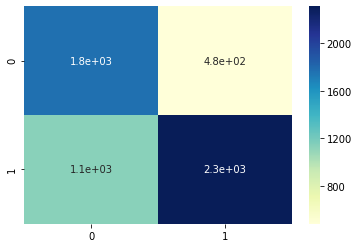

Accuracy: 0.7170474516695958


((                            Coefficient
  age_category                   0.022166
  Extroversion_category          0.022156
  Agreeableness_category         0.026318
  Conscientiousness_category     0.017479
  EM_category                    0.837142
  OTE_category                   0.029651
  orientation                    0.018017
  gender                         0.027070,), array([[1768,  479],
        [1131, 2312]]))

In [106]:
train_xgb(data_s2,features,target)

/Users/jinxiaowei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


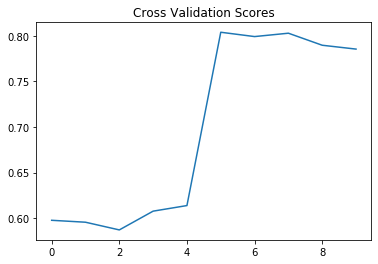

[0.5977859778597786,
 0.595677385345282,
 0.5872430152872957,
 0.6078017923036373,
 0.6139240506329114,
 0.8037974683544303,
 0.7990506329113924,
 0.8027426160337553,
 0.7895569620253164,
 0.7853375527426161]

In [107]:
kfold_cv(data_s2,features,target)

In [108]:
n_estimators = [100,500,1000]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 30.4min finished


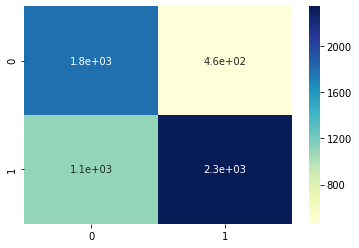

Accuracy: 0.7253075571177504


({'subsample': 0.8,
  'n_estimators': 1000,
  'min_child_weight': 10,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[1785,  461],
        [1102, 2342]]))

In [109]:
grid_search(data_s2,features,target,random_grid,5)

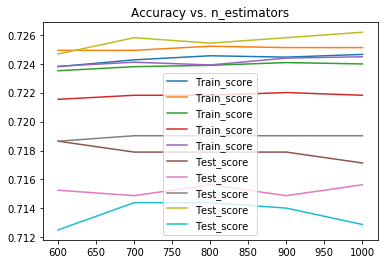

In [110]:
params_test(data_s2,features,target,"n_estimators",[600,700,800,900,1000],5)

In [111]:
n_estimators = [750,800,850]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [750, 800, 850], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 45.8min finished


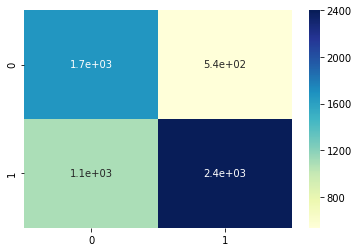

Accuracy: 0.7145869947275922


({'subsample': 1,
  'n_estimators': 850,
  'min_child_weight': 1,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[1665,  535],
        [1089, 2401]]))

In [112]:
grid_search(data_s2,features,target,random_grid,5)

## Personality + Orientation + Gender (Original)

### (i) Depression

In [113]:
features = ['Extroversion','Agreeableness','Conscientiousness', 
            'Emotional_stability','Openness_to_experience',
            'orientation','gender']

target = 'depression_category'

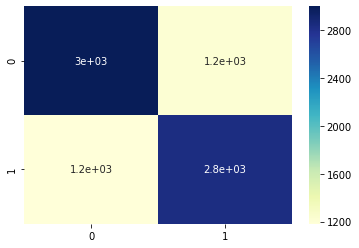

Accuracy: 0.7089850854856311


((                        Coefficient
  Extroversion               0.135562
  Agreeableness              0.024147
  Conscientiousness          0.107094
  Emotional_stability        0.611823
  Openness_to_experience     0.055887
  orientation                0.048425
  gender                     0.017061,), array([[3002, 1218],
        [1182, 2845]]))

In [114]:
train_xgb(data_d,features,target)

/Users/jinxiaowei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


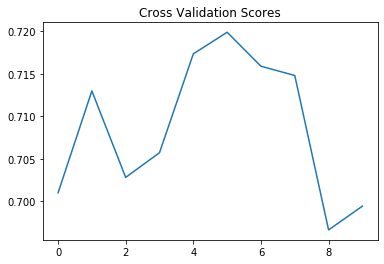

[0.700982175336486,
 0.7129865405602037,
 0.7028010185522008,
 0.7057111676973445,
 0.7173517642779192,
 0.71989814477992,
 0.7158966897053474,
 0.7148053837759185,
 0.6966169516187705,
 0.6994177583697234]

In [115]:
kfold_cv(data_d,features,target)

In [116]:
n_estimators = [100,500,1000]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 40.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 57.0min finished


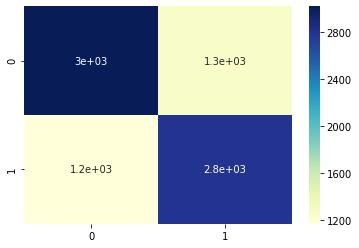

Accuracy: 0.7054686552685825


({'subsample': 0.8,
  'n_estimators': 500,
  'min_child_weight': 10,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[3018, 1264],
        [1165, 2800]]))

In [117]:
grid_search(data_d,features,target,random_grid,5)

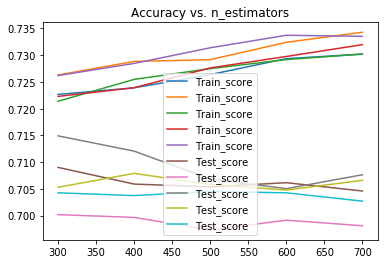

In [119]:
params_test(data_d,features,target,"n_estimators",[300,400,500,600,700],5)

In [120]:
n_estimators = [300,350,400,450,500]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [300, 350, 400, 450, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 44.3min finished


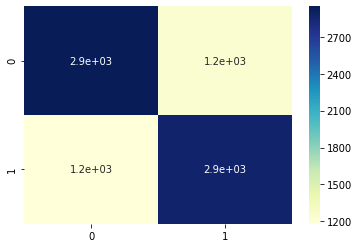

Accuracy: 0.7064387049836304


({'subsample': 0.8,
  'n_estimators': 450,
  'min_child_weight': 10,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2948, 1241],
        [1180, 2878]]))

In [121]:
grid_search(data_d,features,target,random_grid,5)

### (ii) Anxiety

In [122]:
features = ['Extroversion','Agreeableness','Conscientiousness', 
            'Emotional_stability','Openness_to_experience',
            'orientation','gender']

target = 'anxiety_category'

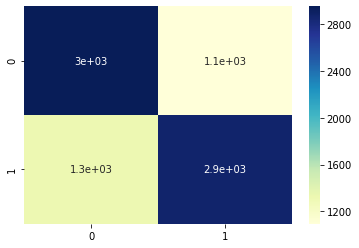

Accuracy: 0.7072874984842973


((                        Coefficient
  Extroversion               0.048652
  Agreeableness              0.019817
  Conscientiousness          0.049094
  Emotional_stability        0.699710
  Openness_to_experience     0.038661
  orientation                0.073320
  gender                     0.070746,), array([[2953, 1094],
        [1320, 2880]]))

In [123]:
train_xgb(data_a,features,target)

/Users/jinxiaowei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


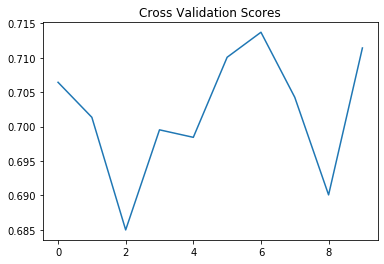

[0.7064387049836304,
 0.7013459439796289,
 0.6849763550381958,
 0.6995271007639141,
 0.6984357948344853,
 0.7100763914150601,
 0.7137140778464897,
 0.7042560931247727,
 0.6900691160421971,
 0.7114264919941776]

In [124]:
kfold_cv(data_a,features,target)

In [125]:
n_estimators = [100,500,1000]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed: 49.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 69.3min finished


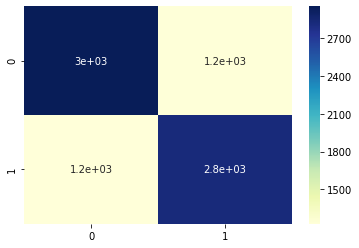

Accuracy: 0.7013459439796289


({'subsample': 0.8,
  'n_estimators': 500,
  'min_child_weight': 10,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2953, 1236],
        [1227, 2831]]))

In [126]:
grid_search(data_a,features,target,random_grid,6)

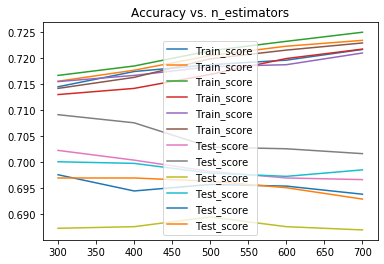

In [127]:
params_test(data_a,features,target,"n_estimators",[300,400,500,600,700],6)

In [128]:
n_estimators = [300,350,400,450]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [300, 350, 400, 450], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 51.9min finished


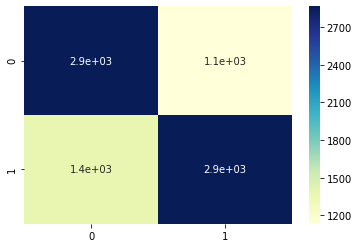

Accuracy: 0.6949193646174366


({'subsample': 1,
  'n_estimators': 400,
  'min_child_weight': 1,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2866, 1133],
        [1383, 2865]]))

In [130]:
grid_search(data_a,features,target,random_grid,6)

### (iii) Stress

In [131]:
features = ['Extroversion','Agreeableness','Conscientiousness', 
            'Emotional_stability','Openness_to_experience',
            'orientation','gender']

target = 'stress_category'

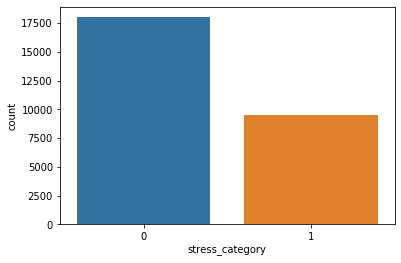

In [133]:
sns.countplot(data_s['stress_category'])

In [134]:
rus = RandomUnderSampler()
X_rus, y_rus= rus.fit_sample(data_s[features], data_s[target])

In [135]:
X_rus['stress_category'] = y_rus

In [136]:
data_s1 = X_rus.copy()

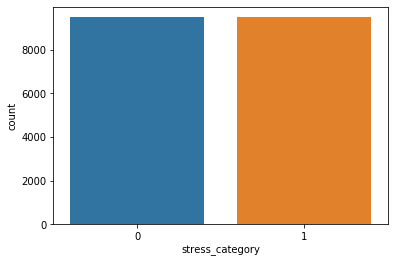

In [137]:
sns.countplot(data_s1['stress_category'])

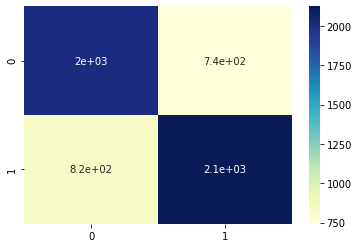

Accuracy: 0.7258347978910369


((                        Coefficient
  Extroversion               0.030897
  Agreeableness              0.037156
  Conscientiousness          0.027219
  Emotional_stability        0.800635
  Openness_to_experience     0.033043
  orientation                0.032802
  gender                     0.038249,), array([[2006,  742],
        [ 818, 2124]]))

In [138]:
train_xgb(data_s1,features,target)

/Users/jinxiaowei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


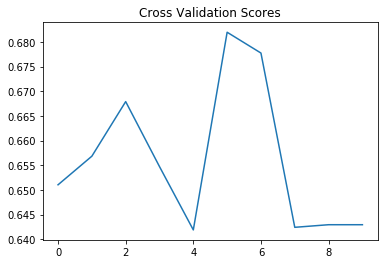

[0.6510279388508171,
 0.6568265682656826,
 0.6678966789667896,
 0.6547179757511861,
 0.6418776371308017,
 0.6819620253164557,
 0.6777426160337553,
 0.6424050632911392,
 0.6429324894514767,
 0.6429324894514767]

In [139]:
kfold_cv(data_s1,features,target)

In [140]:
n_estimators = [100,500,1000]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 36.2min finished


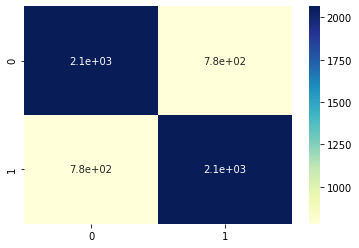

Accuracy: 0.7249560632688928


({'subsample': 1,
  'n_estimators': 100,
  'min_child_weight': 10,
  'max_depth': 50,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2060,  784],
        [ 781, 2065]]))

In [141]:
grid_search(data_s1,features,target,random_grid,5)

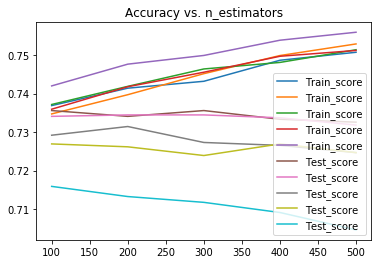

In [142]:
params_test(data_s1,features,target,"n_estimators",[100,200,300,400,500],5)

In [143]:
n_estimators = [100,150,200,250,300]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [100, 150, 200, 250, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 13.3min finished


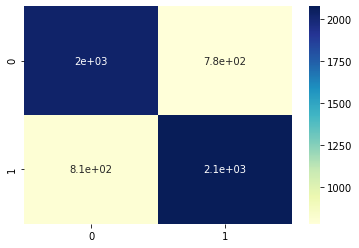

Accuracy: 0.7203866432337435


({'subsample': 0.8,
  'n_estimators': 100,
  'min_child_weight': 5,
  'max_depth': 50,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2026,  784],
        [ 807, 2073]]))

In [144]:
grid_search(data_s1,features,target,random_grid,5)

## Personality + Orientation + Gender (Categorical)

### (i) Depression

In [145]:
features = ['Extroversion_category','Agreeableness_category', 
            'Conscientiousness_category', 'EM_category',
       'OTE_category','orientation','gender']

target = 'depression_category'

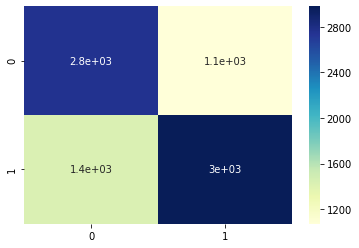

Accuracy: 0.6960106705468655


((                            Coefficient
  Extroversion_category          0.153877
  Agreeableness_category         0.016679
  Conscientiousness_category     0.103194
  EM_category                    0.641052
  OTE_category                   0.045944
  orientation                    0.030556
  gender                         0.008698,), array([[2760, 1072],
        [1435, 2980]]))

In [146]:
train_xgb(data_d,features,target)

/Users/jinxiaowei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


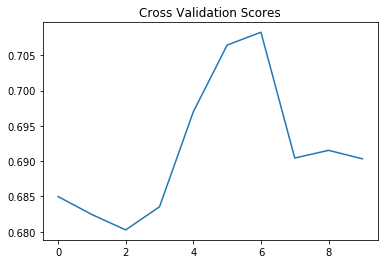

[0.6849763550381958,
 0.682429974536195,
 0.6802473626773372,
 0.6835212804656239,
 0.6969807202619134,
 0.7064387049836304,
 0.7082575481993452,
 0.6904328846853401,
 0.691524190614769,
 0.6903202328966521]

In [147]:
kfold_cv(data_d,features,target)

In [148]:
n_estimators = [100,500,1000]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 45.9min finished


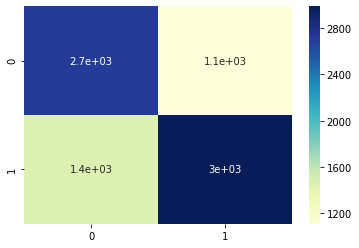

Accuracy: 0.6901903722565782


({'subsample': 0.8,
  'n_estimators': 500,
  'min_child_weight': 10,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2703, 1109],
        [1446, 2989]]))

In [149]:
grid_search(data_d,features,target,random_grid,6)

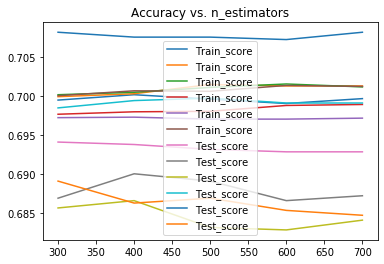

In [151]:
params_test(data_d,features,target,"n_estimators",[300,400,500,600,700],6)

In [152]:
n_estimators = [400,450,500,550]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [400, 450, 500, 550], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 40.7min finished


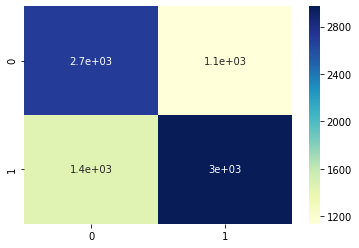

Accuracy: 0.6871589668970535


({'subsample': 0.8,
  'n_estimators': 550,
  'min_child_weight': 10,
  'max_depth': 10,
  'learning_rate': 0.1,
  'gamma': 5},
 array([[2696, 1135],
        [1445, 2971]]))

In [153]:
grid_search(data_d,features,target,random_grid,6)

### (ii) Anxiety

In [154]:
features = ['Extroversion_category','Agreeableness_category', 
            'Conscientiousness_category', 'EM_category',
       'OTE_category','orientation','gender']

target = 'anxiety_category'

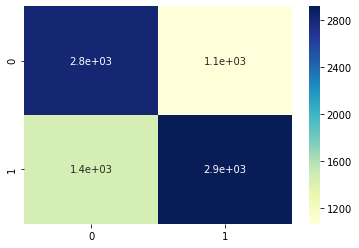

Accuracy: 0.6950406208318176


((                            Coefficient
  Extroversion_category          0.033297
  Agreeableness_category         0.007397
  Conscientiousness_category     0.038915
  EM_category                    0.819166
  OTE_category                   0.030041
  orientation                    0.038859
  gender                         0.032325,), array([[2815, 1065],
        [1450, 2917]]))

In [155]:
train_xgb(data_a,features,target)

/Users/jinxiaowei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


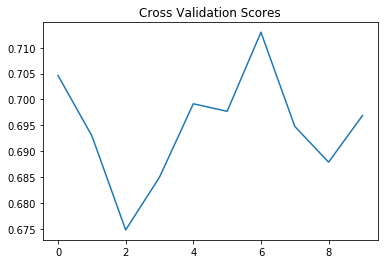

[0.7046198617679156,
 0.6929792651873409,
 0.6747908330301928,
 0.6849763550381958,
 0.6991633321207712,
 0.6977082575481993,
 0.7129865405602037,
 0.6947981084030557,
 0.6878865041833394,
 0.6968704512372634]

In [156]:
kfold_cv(data_a,features,target)

In [157]:
n_estimators = [100,500,1000]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 44.4min finished


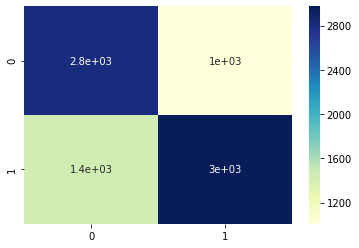

Accuracy: 0.7031647871953438


({'subsample': 1,
  'n_estimators': 500,
  'min_child_weight': 10,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2826, 1008],
        [1440, 2973]]))

In [158]:
grid_search(data_a,features,target,random_grid,6)

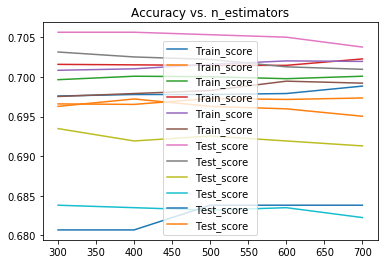

In [159]:
params_test(data_a,features,target,"n_estimators",[300,400,500,600,700],6)

In [160]:
n_estimators = [450,500,550,600]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [450, 500, 550, 600], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 48.3min finished


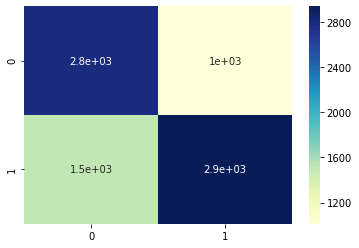

Accuracy: 0.6941918273311507


({'subsample': 0.8,
  'n_estimators': 450,
  'min_child_weight': 10,
  'max_depth': 100,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[2785, 1012],
        [1510, 2940]]))

In [161]:
grid_search(data_a,features,target,random_grid,6)

### (iii) Stress

In [162]:
features = ['Extroversion_category','Agreeableness_category', 
            'Conscientiousness_category', 'EM_category',
       'OTE_category','orientation','gender']

target = 'stress_category'

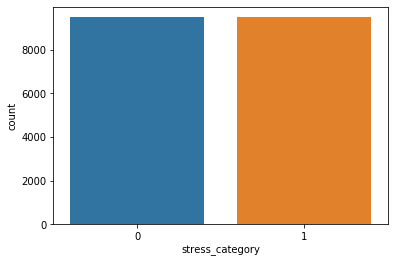

In [163]:
sns.countplot(data_s2[target])

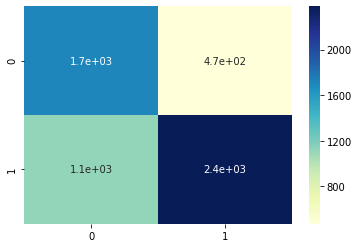

Accuracy: 0.7191564147627416


((                            Coefficient
  Extroversion_category          0.027301
  Agreeableness_category         0.028501
  Conscientiousness_category     0.021992
  EM_category                    0.824026
  OTE_category                   0.035184
  orientation                    0.026886
  gender                         0.036111,), array([[1713,  472],
        [1126, 2379]]))

In [164]:
train_xgb(data_s2,features,target)

/Users/jinxiaowei/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


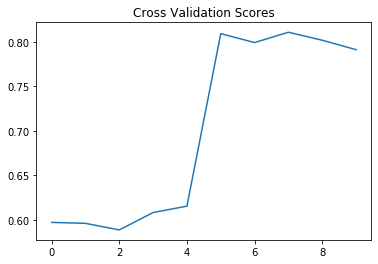

[0.5972588297311544,
 0.5962045334739061,
 0.5888244596731682,
 0.6083289404322615,
 0.615506329113924,
 0.8090717299578059,
 0.7990506329113924,
 0.8106540084388185,
 0.8016877637130801,
 0.7911392405063291]

In [165]:
kfold_cv(data_s2,features,target)

In [166]:
n_estimators = [100,500,1000]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 25.0min finished


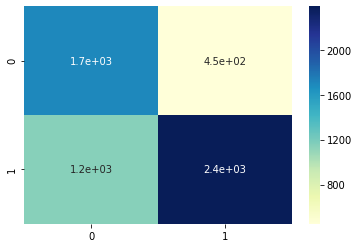

Accuracy: 0.7184534270650264


({'subsample': 1,
  'n_estimators': 500,
  'min_child_weight': 1,
  'max_depth': 10,
  'learning_rate': 0.05,
  'gamma': 5},
 array([[1700,  450],
        [1152, 2388]]))

In [167]:
grid_search(data_s2,features,target,random_grid,5)

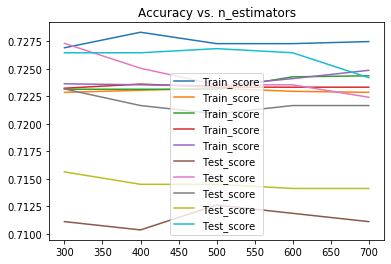

In [168]:
params_test(data_s2,features,target,"n_estimators",[300,400,500,600,700],5)

In [169]:
n_estimators = [300,350,400,450,500]
learning_rate = [0.01,0.05,0.1]
max_depth = [10,50,100]
max_depth.append(None)
subsample = [0.8,1]
min_child_weight = [1,5,10]
gamma = [0,1,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight,
               'gamma': gamma
              }
print(random_grid)

{'n_estimators': [300, 350, 400, 450, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [10, 50, 100, None], 'subsample': [0.8, 1], 'min_child_weight': [1, 5, 10], 'gamma': [0, 1, 5]}


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 19.8min finished


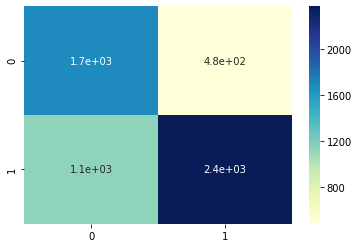

Accuracy: 0.7156414762741652


({'subsample': 1,
  'n_estimators': 300,
  'min_child_weight': 5,
  'max_depth': 10,
  'learning_rate': 0.01,
  'gamma': 5},
 array([[1696,  479],
        [1139, 2376]]))

In [170]:
grid_search(data_s2,features,target,random_grid,5)